For the project to work correctly the data should be held in /archive/ with filenames fraudTest.csv and fraudTrain.csv.
The dataset is: https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

First we load the data into train and test dataframes

In [3]:
train_df = pd.read_csv("archive/fraudTrain.csv")
test_df  = pd.read_csv("archive/fraudTest.csv")

print(train_df.shape, test_df.shape)

(1296675, 23) (555719, 23)


We check for the balance of the dataset. The dataset is highly imbalanced, 0.5% fraud

In [4]:
train_df['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

We'll first encode some columns to work with numeric data, and split the datetime into day and hour, which are more telling than the exact moment itself. We also calculate the age

In [5]:
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
test_df['trans_date_trans_time']  = pd.to_datetime(test_df['trans_date_trans_time'])
train_df['dob'] = pd.to_datetime(train_df['dob'])
test_df['dob'] = pd.to_datetime(test_df['dob'])
train_df['age'] = (train_df['trans_date_trans_time'] - train_df['dob']).dt.days // 365
test_df['age'] = (test_df['trans_date_trans_time'] - test_df['dob']).dt.days // 365
encoder = LabelEncoder()
for df in [train_df, test_df]:
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_day'] = df['trans_date_trans_time'].dt.dayofweek
    df.drop(columns=['trans_date_trans_time'], inplace=True)
    df["merchant"] = encoder.fit_transform(df["merchant"])
    df["category"] = encoder.fit_transform(df["category"])
    df["gender"] = encoder.fit_transform(df["gender"])
    df["job"] = encoder.fit_transform(df["job"])
    df["first"] = encoder.fit_transform(df["first"])
    df["last"] = encoder.fit_transform(df["last"])
    df["street"] = encoder.fit_transform(df["street"])
    df["city"] = encoder.fit_transform(df["city"])
    df["state"] = encoder.fit_transform(df["state"])

We're going to analyze the data for unimportant columns to drop

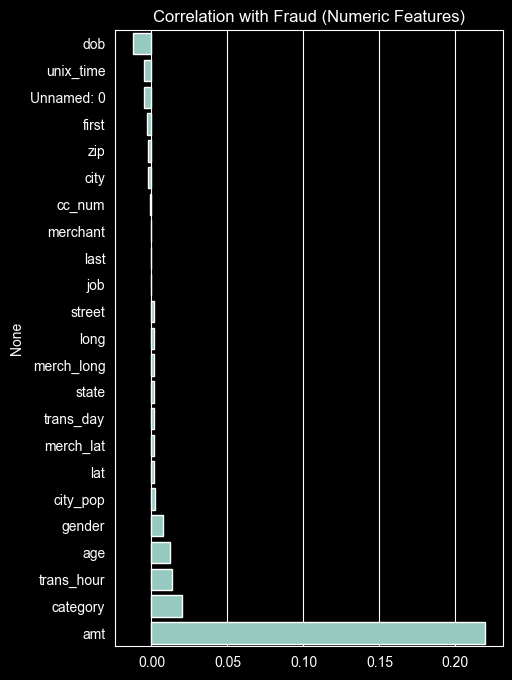

In [6]:
numeric_cols = train_df.select_dtypes(exclude='object').columns
corr = train_df[numeric_cols].corr()['is_fraud'].drop('is_fraud').sort_values()
plt.figure(figsize=(5,8))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation with Fraud (Numeric Features)")
plt.show()

Based on this we create a list of columns to drop, we'll set the cutoff at city_pop

In [7]:
cols_to_drop = ['Unnamed: 0', 'unix_time', 'cc_num', 'merchant', 'job', 'merch_long', 'trans_day', 'merch_lat', 'city_pop', 'first', 'last', 'street', 'city', 'zip','lat', 'state', 'long', 'dob','trans_num', 'cc_num']
train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(train_df.shape, test_df.shape)

(1296675, 6) (555719, 6)


We then split the data into the label and features

In [8]:
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

We scale the data since it's necessary for logistic regression and KNN

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

We'll also use SMOTE to handle imbalance

In [10]:
smote = SMOTE(random_state=67)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print(pd.Series(y_train_res).value_counts())

is_fraud
0    1289169
1    1289169
Name: count, dtype: int64


We will use PR AUC as our main metric, as we're more interested in how many flagged frauds are frauds and how many of all frauds did we catch

In [27]:
def pr_auc_score(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

We will now use the same schematic for each model, creation, fitting, prediction, reporting

Logistic regression

In [32]:
lr = LogisticRegression(max_iter=1000,class_weight='balanced',random_state=67)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred_lr))
print("PR AUC:", pr_auc_score(y_test, y_prob_lr))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.05      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

PR AUC: 0.14431953599294786


Random forest

In [31]:
rf = RandomForestClassifier(n_estimators=10,class_weight='balanced',random_state=67,n_jobs=-1)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred_rf))
print("PR AUC:", pr_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.61      0.84      0.71      2145

    accuracy                           1.00    555719
   macro avg       0.80      0.92      0.85    555719
weighted avg       1.00      1.00      1.00    555719

PR AUC: 0.7831819881249423


KNN

In [35]:
knn = KNeighborsClassifier(n_neighbors=5,weights='distance',n_jobs=-1)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred_knn))
print("PR AUC:", pr_auc_score(y_test, y_prob_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.45      0.87      0.59      2145

    accuracy                           1.00    555719
   macro avg       0.72      0.93      0.79    555719
weighted avg       1.00      1.00      1.00    555719

PR AUC: 0.7107627550153303


We can now summarize and compare the models

In [37]:
summary = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "K Nearest Neighbors"
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_pred_knn)
    ],
    "PR AUC": [
        pr_auc_score(y_test, y_prob_lr),
        pr_auc_score(y_test, y_prob_rf),
        pr_auc_score(y_test, y_pred_knn)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_knn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_knn)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_knn)
    ]
})

summary.sort_values(by="PR AUC", ascending=False)

,Model,ROC AUC,PR AUC,Recall,Precision,F1-score
1,Random Forest,0.965816,0.783182,0.842424,0.607804,0.706135
2,K Nearest Neighbors,0.933338,0.658805,0.870862,0.446249,0.590112
0,Logistic Regression,0.848549,0.144320,0.749184,0.053901,0.100566


The confusion matrix are for logistic regression, random forest and KNN in order. We can see that the case is non-linear since Logistic regression fails completely, the random forest and KNN have much better results with the difference between them probably because of hyperparameter tuning, the final decision would depend on how costly false flagging a fraud would be

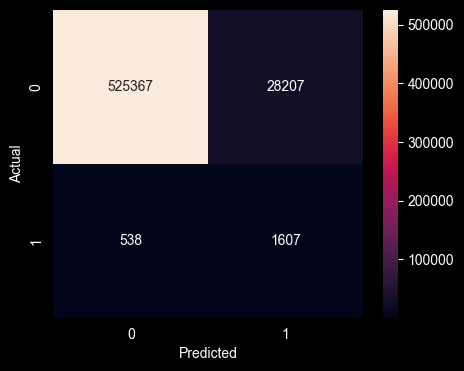

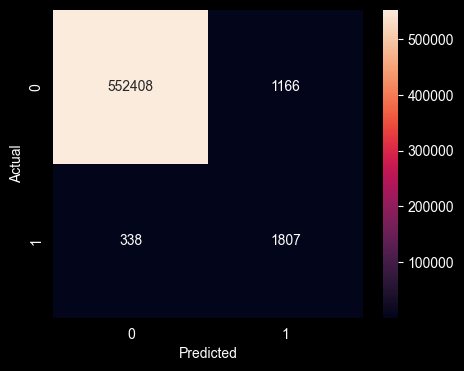

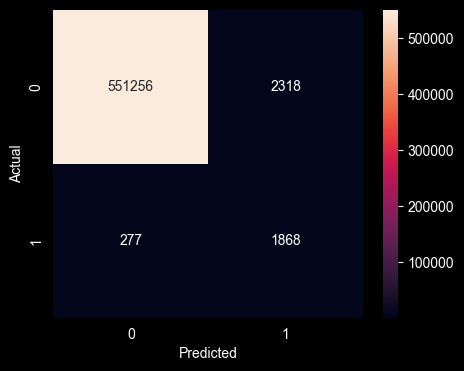

In [38]:
for y in [y_pred_lr, y_pred_rf, y_pred_knn]:
    cm = confusion_matrix(y_test, y)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()